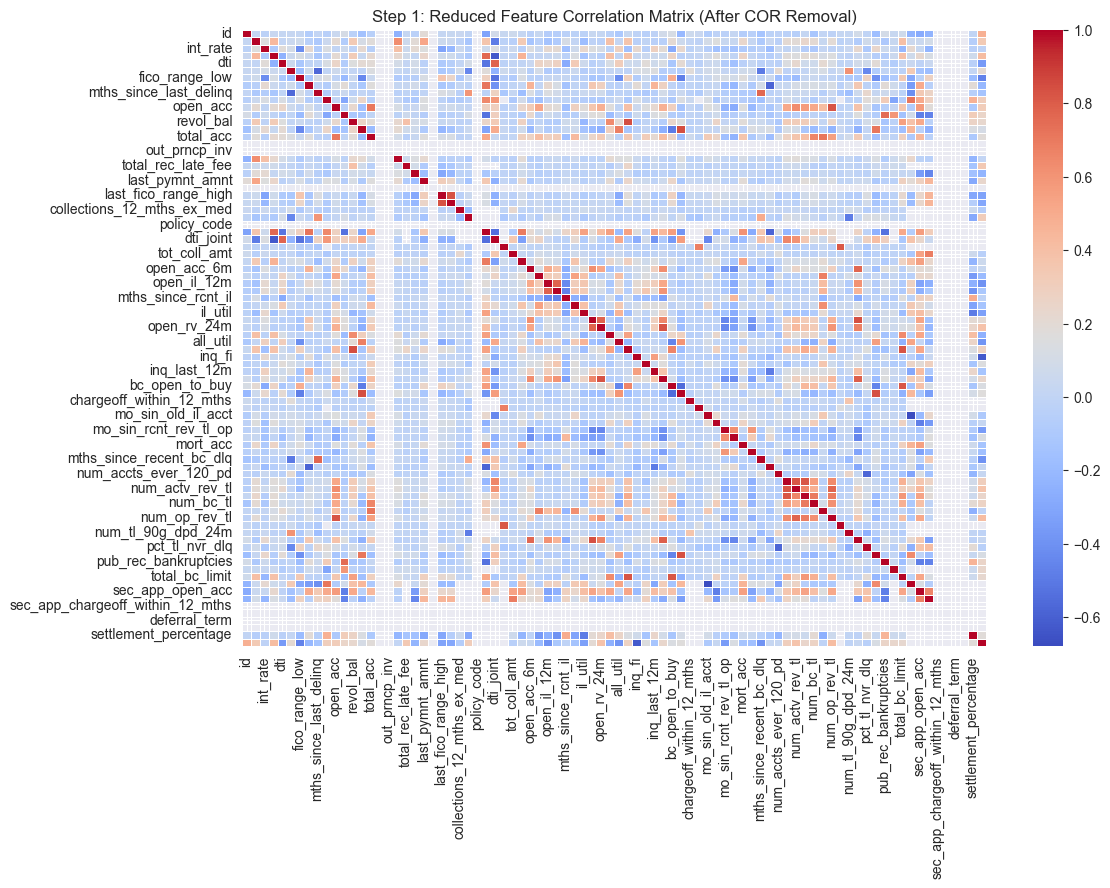

제거된 상관계수 높은 변수 개수: 30
제거된 변수 목록: ['funded_amnt', 'funded_amnt_inv', 'installment', 'fico_range_high', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'collection_recovery_fee', 'avg_cur_bal', 'mths_since_recent_revol_delinq', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_mths_since_last_major_derog', 'hardship_amount', 'hardship_dpd', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'settlement_amount']
제거된 결측치 50% 이상 변수 개수: 72
제거된 파생변수 개수: 23
제거된 변수 목록: ['id', 'emp_title', 'issue_d', 'pymnt_plan', 'url', 'title', 'zip_code', 'addr_state', 'delinq_2yrs', 'earliest_cr_line', 'mths_since_last_delinq', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'last_pymnt_d', 'last_

C:\Users\user\AppData\Local\Temp\ipykernel_125700\2409191743.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feature_importances["Feature"][:20], x=feature_importances["Importance"][:20], palette="Blues_r")


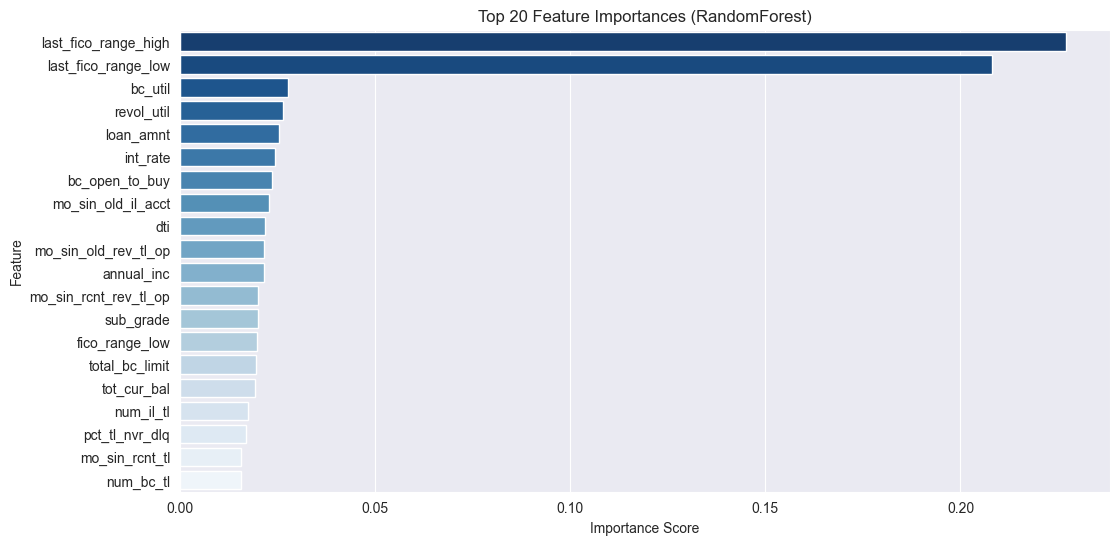

제거된 낮은 중요도 변수 개수: 10
제거된 변수 목록: {'pub_rec', 'collections_12_mths_ex_med', 'pub_rec_bankruptcies', 'num_tl_90g_dpd_24m', 'chargeoff_within_12_mths', 'hardship_flag', 'tax_liens', 'application_type', 'disbursement_method', 'num_tl_30dpd'}
최종 데이터 저장: final_lending_club_feature_importance.csv
최종 남아 있는 변수 개수: 39
최종 남아 있는 변수 목록:
['last_fico_range_high', 'last_fico_range_low', 'bc_util', 'revol_util', 'loan_amnt', 'int_rate', 'bc_open_to_buy', 'mo_sin_old_il_acct', 'dti', 'mo_sin_old_rev_tl_op', 'annual_inc', 'mo_sin_rcnt_rev_tl_op', 'sub_grade', 'fico_range_low', 'total_bc_limit', 'tot_cur_bal', 'num_il_tl', 'pct_tl_nvr_dlq', 'mo_sin_rcnt_tl', 'num_bc_tl', 'open_acc', 'acc_open_past_24mths', 'num_actv_rev_tl', 'grade', 'emp_length', 'percent_bc_gt_75', 'num_bc_sats', 'num_actv_bc_tl', 'num_tl_op_past_12m', 'inq_last_6mths', 'purpose', 'mort_acc', 'term', 'initial_list_status', 'verification_status', 'home_ownership', 'tot_coll_amt', 'num_accts_ever_120_pd', 'loan_status']


In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split


############################
### 상관계수 계산 후 변수 정리 ###
############################

# 원본 데이터 불러오기
file_path = "./lending_club_sample.csv"
df = pd.read_csv(file_path)

# 상관계수 행렬 계산
correlation_matrix = df.corr(numeric_only=True)

# 높은 상관관계를 가진 변수 찾기 (85% 이상)
high_corr_threshold = 0.85
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_vars = [col for col in upper_triangle.columns if any(upper_triangle[col].abs() > high_corr_threshold)]

# 높은 상관계수 변수 제거
df_filtered = df.drop(columns=high_corr_vars)

# 상관계수 히트맵 (제거 후)
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(numeric_only=True), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Step 1: Reduced Feature Correlation Matrix (After COR Removal)")
plt.show()

print(f"제거된 상관계수 높은 변수 개수: {len(high_corr_vars)}")
print(f"제거된 변수 목록: {high_corr_vars}")

# 결측치 비율 계산
missing_ratio = df_filtered.isnull().mean()

# 50% 이상 결측치가 있는 변수 제거
threshold = 0.5
columns_to_keep = missing_ratio[missing_ratio < threshold].index
df_filtered = df_filtered[columns_to_keep].copy()

print(f"제거된 결측치 50% 이상 변수 개수: {len(df.columns) - len(columns_to_keep)}")


####################
### 남은 결측치 처리 ###
####################

# 연속형 변수와 범주형 변수 구분
numerical_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_filtered.select_dtypes(include=['object']).columns

# 연속형 변수: 중위수(median)로 결측치 대체
for col in numerical_cols:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

# 범주형 변수: 최빈값(mode)으로 결측치 대체
for col in categorical_cols:
    if not df_filtered[col].mode().empty:
        df_filtered[col] = df_filtered[col].fillna(df_filtered[col].mode()[0])


##################
### 파생변수 제거 ###
##################

# 필요하지 않은 변수 키워드 목록 (설명 변수, URL, 중복 정보, 사후 변수 등)
derived_variable_keywords = [
    "total_rec", "recoveries", "pymnt", "settlement", "delinq", "mths_since",
    "id", "url", "desc", "title", "zip_code", "addr_state", "policy_code",
    "issue_d", "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d"
]

# 파생변수 및 불필요한 변수 제거
derived_variables = [col for col in df_filtered.columns if any(keyword in col.lower() for keyword in derived_variable_keywords)]
df_filtered = df_filtered.drop(columns=derived_variables)

print(f"제거된 파생변수 개수: {len(derived_variables)}")
print(f"제거된 변수 목록: {derived_variables}")


################################
### 다중공선성(VIF) 기반 변수 제거 ###
################################

# VIF 계산 함수 정의
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [sm.OLS(df[col], sm.add_constant(df.drop(columns=[col]))).fit().rsquared for col in features]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])  # VIF 공식 적용
    return vif_data

# 숫자형 변수만 선택 후 VIF 계산
numerical_cols_vif = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# NaN 및 Inf 값 처리
df_filtered[numerical_cols_vif] = df_filtered[numerical_cols_vif].replace([np.inf, -np.inf], np.nan)
df_filtered[numerical_cols_vif] = df_filtered[numerical_cols_vif].fillna(df_filtered[numerical_cols_vif].median())

# 분산이 0인 열(상수값만 가진 변수) 제거
zero_variance_cols = df_filtered[numerical_cols_vif].columns[df_filtered[numerical_cols_vif].nunique() == 1]
df_filtered = df_filtered.drop(columns=zero_variance_cols)

# numerical_cols_vif 업데이트
numerical_cols_vif = [col for col in numerical_cols_vif if col in df_filtered.columns]

# VIF 계산 실행
try:
    vif_df = calculate_vif(df_filtered[numerical_cols_vif], numerical_cols_vif)
    
    # ✅ VIF 10 이상인 변수 제거
    high_vif_vars = vif_df[vif_df["VIF"] > 10]["Feature"].tolist()
    df_filtered = df_filtered.drop(columns=high_vif_vars)

    print(f"제거된 VIF 높은 변수 개수: {len(high_vif_vars)}")
    print(f"제거된 변수 목록: {high_vif_vars}")

except Exception as e:
    print("VIF 계산 중 오류 발생:", e)

# 최종 데이터 저장
final_data_path = "final_lending_club.csv"
df_filtered.to_csv(final_data_path, index=False)


####################################################################
### RandomForest 이용하여 변수별 중요도 수치화 후 신용 평가에 적합한 변수 선택 ###
####################################################################

# 데이터 로드
df_filtered = pd.read_csv("final_lending_club.csv")

# 범주형 변수 Label Encoding (랜덤 포레스트 모델 적용을 위해 변환)
categorical_cols = df_filtered.select_dtypes(include=['object']).columns
df_encoded = df_filtered.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# 타겟 변수 지정: loan_status
target_variable = "loan_status"
if target_variable in df_encoded.columns:
    X = df_encoded.drop(columns=[target_variable])
    y = df_encoded[target_variable]
else:
    raise KeyError(f"오류: '{target_variable}' 변수가 존재하지 않음")

# 랜덤 포레스트 모델 훈련 (변수 중요도 분석)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 변수 중요도 계산
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(12, 6))
sns.barplot(y=feature_importances["Feature"][:20], x=feature_importances["Importance"][:20], palette="Blues_r")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# 중요도가 낮은 변수 제거 (상위 80% 변수만 유지)
threshold = feature_importances["Importance"].quantile(0.2)  # 하위 20% 변수 제거
selected_features = feature_importances[feature_importances["Importance"] > threshold]["Feature"].tolist()
df_filtered = df_filtered[selected_features + [target_variable]]  # 타겟 변수 포함

print(f"제거된 낮은 중요도 변수 개수: {len(feature_importances) - len(selected_features)}")
print(f"제거된 변수 목록: {set(feature_importances['Feature']) - set(selected_features)}")

# 최적화된 데이터 저장 (Feature Importance 기반)
final_data_path_fi = "final_lending_club_feature_importance.csv"
df_filtered.to_csv(final_data_path_fi, index=False)
print(f"최종 데이터 저장: {final_data_path_fi}")

# 남아 있는 변수 개수 및 목록 출력
remaining_variables = df_filtered.columns.tolist()
num_remaining_variables = len(remaining_variables)

print(f"최종 남아 있는 변수 개수: {num_remaining_variables}")
print(f"최종 남아 있는 변수 목록:\n{remaining_variables}")

In [18]:
df_final = pd.read_csv("final_lending_club_feature_importance.csv")

# non-default = 0, default = 1
df_final['loan_status'] = df_final['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

df1 = df_final.drop(columns=df_final.select_dtypes(include=['object', 'category']).columns.tolist())
df1


,last_fico_range_high,last_fico_range_low,bc_util,revol_util,loan_amnt,int_rate,bc_open_to_buy,mo_sin_old_il_acct,dti,mo_sin_old_rev_tl_op,...,num_actv_rev_tl,percent_bc_gt_75,num_bc_sats,num_actv_bc_tl,num_tl_op_past_12m,inq_last_6mths,mort_acc,tot_coll_amt,num_accts_ever_120_pd,loan_status
0,744.0,740.0,64.90,64.9,20000.0,13.99,6146.0,183.0,13.68,37.0,...,5.0,66.7,3.0,3.0,2.0,2.0,3.0,0.0,0.0,0
1,664.0,660.0,43.50,27.3,7000.0,9.16,10852.0,86.0,22.39,152.0,...,4.0,25.0,4.0,4.0,4.0,0.0,1.0,0.0,0.0,0
2,524.0,520.0,81.90,69.7,20000.0,8.67,5132.0,151.0,29.14,204.0,...,18.0,57.1,14.0,14.0,1.0,0.0,4.0,323.0,0.0,0
3,744.0,740.0,43.10,40.5,16000.0,14.46,43792.0,148.0,34.64,223.0,...,5.0,33.3,6.0,5.0,0.0,0.0,0.0,60.0,0.0,0
4,694.0,690.0,64.95,85.2,4000.0,11.53,4006.0,154.0,24.27,282.0,...,3.0,50.0,0.0,0.0,2.0,0.0,2.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,584.0,580.0,70.60,82.6,21000.0,25.82,3531.0,121.0,22.67,189.0,...,6.0,66.7,2.0,3.0,6.0,0.0,2.0,0.0,0.0,0
996,669.0,665.0,0.00,1.2,10625.0,17.57,6000.0,133.0,18.89,157.0,...,3.0,0.0,3.0,0.0,5.0,2.0,1.0,0.0,0.0,0
997,664.0,660.0,65.50,37.6,7000.0,8.18,3653.0,138.0,33.61,199.0,...,7.0,50.0,4.0,3.0,4.0,1.0,0.0,0.0,0.0,0
998,659.0,655.0,80.30,61.9,8000.0,13.35,3801.0,143.0,22.69,141.0,...,15.0,81.8,11.0,10.0,2.0,0.0,0.0,0.0,0.0,0


In [19]:
# 타겟 변수와 feature 분리
target_variable = "loan_status"
X = df1.drop(columns=[target_variable])
y = df1[target_variable]

# 타겟 변수가 문자열인 경우 Label Encoding 진행
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

# 학습/테스트 데이터 분할 (예: 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# RandomForestClassifier 모델 학습
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 테스트 데이터에 대해 예측 수행
y_pred = clf.predict(X_test)

# F1 Score 계산 (클래스 불균형이 있을 수 있으므로 weighted average 사용)
f1 = f1_score(y_test, y_pred, average="weighted")
print("F1 Score:", f1)

# 추가로 분류 리포트 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


F1 Score: 0.898125

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       158
           1       0.79      0.71      0.75        42

    accuracy                           0.90       200
   macro avg       0.86      0.83      0.84       200
weighted avg       0.90      0.90      0.90       200

